In [3]:
 #mount google drive with images
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
#imports as usual
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import classification_report, confusion_matrix

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version is {}'.format(tf.__version__))

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

import cv2
from google.colab.patches import cv2_imshow


TensorFlow version is 2.2.0


We create a function to create new models, with trainable top layers.

In [0]:
###https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
#https://www.tensorflow.org/tutorials/keras/
#https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/keras/custom_callback.ipynb#scrollTo=Ct0VCSI2dt3a
#above reference is related to callbacks, modularity of training, and CAMs

#We have to use this function to create a model onto which we load pre-trained values
def create_model():
    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
        -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

    #import inceptron_v3, and make entire model untrainable
    local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    pre_trained_model = InceptionV3(
        input_shape=(150, 150, 3), include_top=False, weights=None)
    pre_trained_model.load_weights(local_weights_file)

    #lets make the model non-trainable, since we will only use it for feature extraction
    #we wont update the weights of the pretrained model during training
    for layer in pre_trained_model.layers:
      layer.trainable = False

    unfreeze = False
    for layer in pre_trained_model.layers:
      if unfreeze:
        layer.trainable = True
      if layer.name == 'mixed6':
        unfreeze = True

    #The layer we will use for feature extraction  is called mixed7. 
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
    #flatten the last convolutional layer, add a FC layer
    x = layers.Flatten()(last_output)
    #Add a fully connected layer with 1,024 hidden units and ReLU activation
    #Add a regularizing dropout layer
    #Add a final softmax layer
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(10, activation='softmax')(x)

    # Configure and compile the model
    model = Model(pre_trained_model.input, x)
    # Return pre-compiled model

    return model

Hopefully we can load the best model that we have trained previously!

In [105]:
#load our best model from another notebook
loaded_model = create_model()
loaded_model.load_weights("drive/My Drive/SupportClassification/ten_supports/ten_class_weights/ten_class_weights_p3.hdf5.ckpt")

--2020-06-06 15:47:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   136MB/s    in 0.6s    

2020-06-06 15:47:08 (136 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
#only if you want to learn something about the model structure
loaded_model.summary()

In [0]:
#https://matplotlib.org/3.1.1/tutorials/text/text_intro.html
#helper function to plot probability distribution across materials
def plot_class_distributions(preds):

    preds.tolist()

    target_names = ('Al$_2$O$_3$', 'CeO$_2$', 'Co$_2$O$_3$', 'MgO', 'NPs', 'POF', 'SiO$_2$Al$_2$O$_3$-30%', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$')

    fig = plt.figure(figsize=(5.3,5.3))
    
    ax = fig.add_subplot(111)
    
    y_pos = np.arange(len(preds))
    plt.bar(y_pos, preds, color=[(.753, 0, 0, 1), (1, 0, 0, 1), (1, .753, 1, 1), (1, 1, 0, 1), (.573, .816, .314, 1), (0, .690, .314, 1), (0, .690, .941, 1), (0, .439, .753, 1), (0, .125, .376, 1), (.439, .188, .627, 1)])
    plt.yticks(fontsize = 14)
    ax.yaxis.tick_right()
    ax.set_ylabel('Predicted Class Probability', fontsize=14)
    ax.yaxis.set_label_position("right")    

    plt.xticks(y_pos, target_names, rotation = 90, fontsize = 14)

    plt.show()

Our class predictions are: [[2.0824751e-01 5.4855245e-01 2.4727198e-05 1.8772376e-01 2.2202552e-05
  7.4768654e-04 8.0415350e-04 3.0335323e-06 6.1995736e-03 4.7674883e-02]]
For Al2O3 our prediction is 21.0
For CeO2 our prediction is 55.0
For Co2O3 our prediction is 0.0
For MgO our prediction is 19.0
For NPs our prediction is 0.0
For POF our prediction is 0.0
For SiO2Al2O3-30% our prediction is 0.0
For SiO2NBs-NBs our prediction is 0.0
For SiO2-a our prediction is 1.0
For TiO_2 our prediction is 5.0
Preds are now [[2.0824751e-01 5.4855245e-01 2.4727198e-05 1.8772376e-01 2.2202552e-05
  7.4768654e-04 8.0415350e-04 3.0335323e-06 6.1995736e-03 4.7674883e-02]]


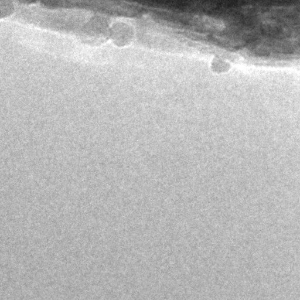

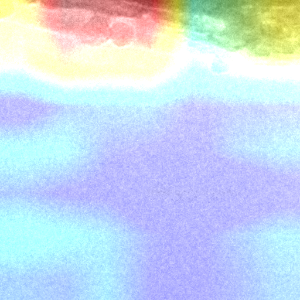

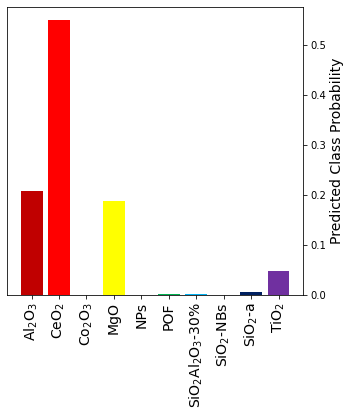

In [443]:
#class activation map for material !!
def image_CAM(ORIGINAL):

    #load the original image
    #process to put it through the network
    img = image.load_img(ORIGINAL, target_size=(150, 150)) #load image as PIL.image.image
    x = image.img_to_array(img) #convert to numpy array (150, 150, 3)
    x = np.expand_dims(x, axis=0) #add that extra dimension (1, 150, 150, 3)
    #x = preprocess_input(x) #this it the preprocessing step used in the tutorial...
    x = x*1/255 #I hope this is the right preprocessing step... its what our image generator did

    preds = loaded_model.predict(x)

    with tf.GradientTape() as tape:
      last_conv_layer = loaded_model.get_layer('conv2d_539') #sometimes this changes?
      iterate = tf.keras.models.Model([loaded_model.inputs], [loaded_model.output, last_conv_layer.output])
      model_out, last_conv_layer = iterate(x)
      class_out = model_out[:, np.argmax(model_out[0])]
      grads = tape.gradient(class_out, last_conv_layer)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))

    #now show image with heatmap
    img = cv2.imread(ORIGINAL)
    img = cv2.resize(img, (300, 300)) 
    img_original = img                   # Resize image
    INTENSITY = 0.5
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    img = heatmap * INTENSITY + img
    cv2_imshow(img_original)
    cv2_imshow(img)

    

    plot_class_distributions(preds[0])

##########################
target_names = ['Al2O3', 'CeO2', 'Co2O3', 'MgO', 'NPs', 'POF', 'SiO2Al2O3-30%', 'SiO2NBs-NBs', 'SiO2-a', 'TiO_2']
#ORIGINAL = 'EG456INTER_0009img512_0.jpg'
#ORIGINAL = 'EG21-PdNPs_0014img0_512.jpg'
ORIGINAL = '5nm_Ru_CeO2_FT_0026img512_512.jpg'
#ORIGINAL = '44.jpg'

preds = image_CAM(ORIGINAL)